# Teaching a Computer to Play Tic Tac Toe using the Q-Learning Algorithm

When I first started my journey towards becoming a data scientist, I had to learn Python's Pandas library to manipulate dataframes. At the time, I challenged myself to build a tic-tac-toe game using Pandas because I believe that the best way to learn how to code is to build projects. Several years later, when I became a more seasoned data scientist, I revisited this project to train a computer how to play tic-tac-toe, this time testing my understanding of a reinforcement learning algorithm called Q-learning. In this report, I will detail how I developed a multiplayer tic-tac-toe game, and how I trained a computer to play this age-old game. 

In [46]:
!pip install tabulate
import numpy as np
import pandas as pd
import os # import for clear output to not re-print table each time
import sys # to quit program 
from tabulate import tabulate
from itertools import product
import random
import matplotlib.pyplot as plt

### Multiplayer tic-tac-toe

There were some fundamental design decisions I made before coding the tic-tac-toe game, namely:
- the game would be played using a Terminal/command prompt.
    - This reduces the amount of code that would need to be written, all the while maintaining all the necessary functionality of the game to test my knowledge of the Pandas library.
- The tic-tac-toe board would be modelled as a 3 by 3 Pandas dataframe. 
    - The location of the 'X' or 'O' would be referenced using a 2-digit number representing the row and column values, respectively, e.g. '22' for the spot at the center of the table.
- I will use the `tabulate` library to make a nicer looking board.

In [47]:
df = pd.DataFrame(index = range(1,4), columns = range(1,4)) # creating empty df for the tic tac toe board
print(tabulate(df.fillna(' '), headers='keys', tablefmt='fancy_grid'))

╒════╤═════╤═════╤═════╕
│    │ 1   │ 2   │ 3   │
╞════╪═════╪═════╪═════╡
│  1 │     │     │     │
├────┼─────┼─────┼─────┤
│  2 │     │     │     │
├────┼─────┼─────┼─────┤
│  3 │     │     │     │
╘════╧═════╧═════╧═════╛


I then had to consider the general flow of the game:
- Show blank grid below the game instructions.
- Prompt player 1 to enter a 2-digit number representing the location of X.
- Update the board with X given the location provided.
- Prompt player 2 to enter a 2-digit number representing the location of 0.
- Update the board with X given the location provided.
- Repeat until game ends. 

We use `fillna` to print a blank instead of `nan` in the dataframe. We also use a counter, `count`, to determine whose turn it is to play, i.e. Player 1 (X) or Player 2 (O). By convention, we choose Player 1 (X) as the first to play - hence if `count` modulo 2 is equal to 0, we display the prompt for Player 1, otherwise we display the prompt for Player 2. 

In [50]:
## count = 0
# switches between player 1 and 2
if (count % 2) == 0:
    player = ('Player 1','X')
else:
    player = ('Player 2','O')

# gets player input
player_input = str(input('{}({}): enter a 2-digit number representing a row and column: '.format(player[0],player[1])))
if player[0]=='Player 1':
        df.iloc[int(player_input[0])-1,int(player_input[1])- 1] = 'X'
else:
        df.iloc[int(player_input[0])-1,int(player_input[1])- 1] = 'O'
print(tabulate(df.fillna(' '), headers='keys', tablefmt='fancy_grid'))

Player 1(X): enter a 2-digit number representing a row and column: 22
╒════╤═════╤═════╤═════╕
│    │ 1   │ 2   │ 3   │
╞════╪═════╪═════╪═════╡
│  1 │ X   │     │     │
├────┼─────┼─────┼─────┤
│  2 │     │ X   │     │
├────┼─────┼─────┼─────┤
│  3 │     │     │     │
╘════╧═════╧═════╧═════╛


We now need to consider edge cases and end states for the games. Edge cases are user inputs that might "break" the game, i.e. cause a bug in the script. This would happen if the player enters an invalid input, e.g. '123' or 'gh7.'

To prevent this from happening, we start by creating a list of valid inputs, `input_lst`, and test the user's inputs against this list using an `if` statement. If the input check does not pass, the player gets an error message and is asked to re-enter their input. 

As the game progresses, the list of invalid inputs starts to contain entries which we considered otherwise valid. For instance, I cannot enter the number '33' if the bottom right of the table already contains an X or O. As a result, `input_lst` is a running list which gets reduced with previous valid entries from the players. To update the list, we use the `.remove` method. 

In [31]:
count = 0
input_lst = ['11', '12', '13', '21', '22', '23', '31', '32', '33'] 
print('Valid inputs: ',input_lst)
player_input = str(input('Enter a 2-digit number representing a row and column: '))
remove_number = player_input[0] + player_input[1]
input_lst.remove(remove_number)
player_input = str(input('Enter a 2-digit number representing a row and column: '))
if player_input not in input_lst:
    print('Invalid input. You can enter any number from the following list:' , ', '.join(input_lst))

Valid inputs:  ['11', '12', '13', '21', '22', '23', '31', '32', '33']
Enter a 2-digit number representing a row and column: 33
Enter a 2-digit number representing a row and column: 123
Invalid input. You can enter any number from the following list: 11, 12, 13, 21, 22, 23, 31, 32


We now need to consider end states of the game, which are threefold:
1. Player 1 (X) wins.
2. Player 2 (O) wins.
3. Tie game.

To check for these end states, after each user input, we update the board and check if there are 3 Xs or Os representing the following victories:
- win by columns
    - locations 11,12,13 or 21,22,23 or 31,32,33
- win by rows
    - locations 11,12,13 or 21,22,23 or 31,32,33
- win by diagonals
    - locations 11,22,33 or 13,22,31
    
I perform this check after each player selection, and use the `.values` method in Pandas to check if there are 3 Xs or Os in the locations of interest. If a player has won, I print the result and exit the game. 

In [51]:
# checks if player won
if (list(df[1].values) == (3 * [player[1]])) | (list(df[2].values) == (3 * [player[1]])) | (list(df[3].values) == (3 * [player[1]])): # wins by matching columns
    print ("{} wins".format(player[0]))
    sys.exit()
if (list(df.iloc[0]) == (3 * [player[1]])) | (list(df.iloc[1]) == (3 * [player[1]])) | (list(df.iloc[2]) == (3 * [player[1]])): # wins by matching rows
    print ("{} wins".format(player[0]))
    sys.exit()
if ([df.iloc[0, 0], df.iloc[1, 1], df.iloc[2, 2]] == (3 * [player[1]])) | ([df.iloc[0, 2], df.iloc[1, 1], df.iloc[2, 0]] == (3 * [player[1]])): # wins by matching columns
    print ("{} wins".format(player[0]))
    sys.exit()

A tie game happens when there are no winners and no places on the board to put an X or O. Given we increment `count` after each valid player input, a tie game happens when none of the win `if` statements are True and when `count=0`. 

Putting it all together, we can now complete the multiplayer tic-toc-toe game. The full code is included in the appendix within the `play_game_multiplayer()` function. Here is a summary of the gameplay:
- The game is played from the Terminal/command prompt. 
- Instructions are printed on the screen, as well as a blank tic-tac-toe board.
- Each player is prompted to enter a 2-digit number - Player 1 (x) is first.
- If player entries are invalid, an error message appears including the list of valid inputs. This error message continues to appear until a valid input is submitted.
- If there is a winner, the game ends after a print statement stating which player won.
- If it's a tie, the game ends after and the following message is printed "It's a tie."

### Teaching a computer to play tic-tac-toe

Now that we have coded a multiplayer tic-tac-toe game, let's train a computer to behave as one of the human players. To do so, we will be using the Q-learning algorithm, a technique commonly used in reinforcement learning. To best understand the inner workings of this algorithm, we will be implementing it from scratch in lieu of using pre-existing libraries.

##### Q-learning table

The Q-learning algorithm works by recording all actions and states of the game into a table.
- The rows of the table represent each board state.
- The columns represent each action.
- The values in the table represent the score of doing a particular action in a given state.
    - These values are updated using the Q-function which will be detailed in the next section. 
    
The image below illustrates this table. Image source: https://medium.com/@carsten.friedrich/part-3-tabular-q-learning-a-tic-tac-toe-player-that-gets-better-and-better-fa4da4b0892a. 

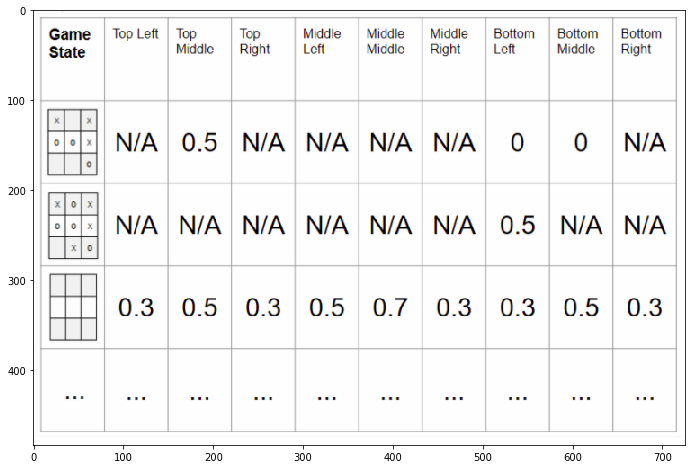

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [12, 8]
img = mpimg.imread('table_image.png')
imgplot = plt.imshow(img)

I chose to represent the rows as a 9-character string representing the board state. The state in the dataframe below would be equal to `'XEXOOXEEO'`. 
- From left to right:
    - The first 3 elements of the string represent the first row of the board.
    - Elements 4, 5 and 6 represent the second row of the board.
    - Elements 7, 8 and 9 represent the third row of the board.
- There is a `'X'` in the string where a X is placed.
- There is a `'O'` in the string where a O is placed.
- There is a `'E'` where there is an empty cell on the board (neither Xs nor Os). 

In [53]:
df = pd.DataFrame(index = range(1,4), columns = range(1,4)) # creating empty df for the tic tac toe board
df.iloc[0,0], df.iloc[0,1], df.iloc[0,2] =  'X', '', 'X'
df.iloc[1,0], df.iloc[1,1], df.iloc[1,2] =  'O', 'O', 'X'
df.iloc[2,0], df.iloc[2,1], df.iloc[2,2] =  '', '', 'O'
print(tabulate(df.fillna(' '), headers='keys', tablefmt='fancy_grid'))

╒════╤═════╤═════╤═════╕
│    │ 1   │ 2   │ 3   │
╞════╪═════╪═════╪═════╡
│  1 │ X   │     │ X   │
├────┼─────┼─────┼─────┤
│  2 │ O   │ O   │ X   │
├────┼─────┼─────┼─────┤
│  3 │     │     │ O   │
╘════╧═════╧═════╧═════╛


As previously mentioned, the columns are the actions that can be taken, i.e. the 9 locations of the tic-tac-toe grid. 
1. Top Left (corresponding action/player input: 11)
2. Top Middle (corresponding action/player input: 12)
3. Top Right (corresponding action/player input: 13)
4. Middle Left (corresponding action/player input: 21)
5. Middle Middle (corresponding action/player input: 22)
6. Middle Right (corresponding action/player input: 23)
7. Bottom Left (corresponding action/player input: 31)
8. Bottom Middle (corresponding action/player input: 32)
9. Bottom Right (corresponding action/player input: 33)

We can now instantiate this Q-matrix given these rows and columns using a pandas dataframe. The first and only row we have for now is the first game state when the board is completely empty (`EEEEEEEEE`). All values in the Q-table are initialized to 0.

In [54]:
# initialize board state
initial_state = 9*'E'
state_t = initial_state

# initialize Q-learning table
actions_lst = ['11','12','13','21','22','23','31','32','33']
actions_dict = {i: actions_lst[i] for i in range(len(actions_lst))} # map action to 1,2...9
q_learning_df = pd.DataFrame(columns=actions_lst,index=['EEEEEEEEE']) # empty df with action lst as columns
q_learning_df.fillna(0)

,11,12,13,21,22,23,31,32,33
EEEEEEEEE,0,0,0,0,0,0,0,0,0


##### Q function

'Q' in Q-learning stands for quality, which is the value generated from an action in the form of a reward. The q-function is used to update the Q-table for a given row (state) and column (action). It is written below and also known as Bellman's equation. 

$ Q(S,A)= Q(S,A) + α \times(R + γ \times maxaQ(S′,a)− Q(S,A)) $

where
- Q(S, A) is the new value in the Q-table for a given state S (row) and action A (column). In other words, it is the new value after the an action is taken given a board state. 
- α is the learning rate. For this analysis `α = 0.9`.
- γ is the discount factor which we set to `γ = 0.95`.
- S' is the next state after taking action A.
- *maxaQ*(S′, a) is the highest Q value of an action A in S′, which will represent the Q value of the best move in the next state.
- R is the reward after an action A. We set the reward using the following values:
    - `R = 1` if action leads to victory.
    - `R = -1` if action leads to defeat.
    - `R = 0.5` if action leads to a tie.
    - `R = 0` if otherwise, i.e. if the game continues without a specific game outcome (next player's turn).

In [55]:
# set Q-learning table params
alpha = 0.9
gamma = 0.95

# conditon for game win/loss
X_wins = 3*'X'
O_wins = 3*'O'

# rewards
reward_win = 1
reward_loss = -1
reward_tie = 0.5
reward_continue = 0

##### Finding all the game states

The Q-table assumes knowledge of all possible positions on the board. One salient way to do this is to find all these combinations using a branch of mathematics called combinatorics. Another way to do this is to dynamically generate all these positions through gameplay. I've developed an algorithm, illustrated in the diagram below, which incorporates both the Q function and a way to update all game states. 

In [56]:
from IPython.core.display import display, HTML
display(HTML('<img src="tic_tac_toe_drawing.png" width="800" height="600"/>'))

Below is a description of the flow of the algorithm.
1. Look at the state of the board and check the table index to find if the state of the board exists in the Q-table.
    - If it doesn't exist, add it as a row and initialize the values to 0.
    - If is does, look at the values for that row.
2. Selection the action the computer should take given possibilities on the board.
    - action is the column of the table associated with the max value score.
    - if there is a tie amongst values, choose randomly.
3. After the action, a new state S' will be created. 
    - Check is S' is in table, and add it if it isn't (again initializing values to 0.)
4. Check the board to see if an end state has been reached, i.e. a win or tie in the case where player X, the computer, just played.
    - If the game status is "win" then set reward `R = 1`, update the new Q-value for the action and state using the Q-function, and increment number of wins plus 1.
    - If the game status is "tie" then set reward `R = 0.5`, update the new Q-value for the action and state using the Q-function, and increment the number of ties plus 1.
5. If end state has not reached, set the game status variable to `'continue'`, after which player 0, the opponent, makes their move.
6. After player 0 plays, the state S'' is created.
7. Check game state of S'', which can be either a loss, a tie, or 'continue'.
    - If the game status is "loss" then set reward `R = -1`, update the new Q-value for the action and state using the Q-function, and increment number of losses plus 1.
    - If the game status is "tie" then set reward `R = 0.5`, update the new Q-value for the action and state using the Q-function, and increment the number of ties plus 1. 
8. If the game status after the opponent's move is 'continue' then set reward `R = 0` 
9. Update the Q values given `R = 0` given the Q-function. 
10. Set S'' as the new initial state S and repeat from step 2.

To implement the algorithm above, I created a series of functions included in the Appendix, namely:
- `check_add_state(state,q_learning_df)` does step 1 and 6
- `select_action(state,q_learning_df)` does step 2
- `new_state_s1(action,state_t)` does step 3
- `game_status_player_X(state)` does step 4 and 5
- `game_status_player_O(state)` does 7 and 8
- `reward(game_status)` does steps 4, 7 and 8
- `update_q_table(state_t,state_t1,action,q_learning_df,reward)` does step 9
- `opponent_play(state_t1)` does step 10

##### Training results

To train a computer using the Q-learning algorithm, we make it play 1000 games against an opponent which randomly makes selections on the board. The computer will be player X and the random player will be player O. We set `n = 1000` as the number of games and record the game outcomes: wins, losses and ties. 
- `q_learning_df` is the Q-table implemented as a pandas dataframe. This dataframe will get filled in with new states (rows) and values as more games are played.
- `results` is a list containing the game outcomes after `n = 1000` games.

In [88]:
# train the agent to play against an opponent that plays randomly
num_games = 1000 # number of games for training
results = [] # score tally

while len(results)<=num_games-1:
    q_learning_df = check_add_state(state_t,q_learning_df)
    action = select_action(state_t,q_learning_df)
    state_t1 = new_state_s1(action,state_t)
    q_learning_df = check_add_state(state_t1,q_learning_df)
    game_status_playerX = game_status_player_X(state_t1)
    rewardX = reward(game_status_playerX)

    if game_status_playerX[0] != 'continue':
        q_learning_df = update_q_table(state_t,state_t1,action,q_learning_df,rewardX)
        results.append(game_status_playerX[0])
        state_t = initial_state

    else:
        state_t2 = opponent_play(state_t1)
        game_status_playerO = game_status_player_O(state_t2)
        rewardO = reward(game_status_playerO)

        if game_status_playerO[0] != 'continue':
            q_learning_df = update_q_table(state_t,state_t1,action,q_learning_df,rewardO)
            results.append(game_status_playerO[0])
            state_t = initial_state
        else:
            q_learning_df = update_q_table(state_t,state_t1,action,q_learning_df,rewardO)
            state_t = state_t2

The results are printed below. As we play more games, we expect that the number of wins to increase and losses to decrease. Our results confirm that the computer has learned to play tic-tac-toe.

In [113]:
num_games_eval = 25
print('Loss percentage in first {} games: '.format(num_games_eval),round(results[:num_games_eval].count('loss')/num_games_eval*100),'%')
print('Win percentage in first {} games: '.format(num_games_eval),round(results[:num_games_eval].count('win')/num_games_eval*100),'%')
print('Tie percentage in first {} games: '.format(num_games_eval),round(results[:num_games_eval].count('tie')/num_games_eval*100),'% \n')

print('Loss percentage in last {} games: '.format(num_games_eval),round(results[-num_games_eval:].count('loss')/num_games_eval*100),'%')
print('Win percentage in last {} games: '.format(num_games_eval),round(results[-num_games_eval:].count('win')/num_games_eval*100),'%')
print('Tie percentage in last {} games: '.format(num_games_eval),round(results[-num_games_eval:].count('tie')/num_games_eval*100),'%')

Loss percentage in first 25 games:  60 %
Win percentage in first 25 games:  24 %
Tie percentage in first 25 games:  16 % 

Loss percentage in last 25 games:  28 %
Win percentage in last 25 games:  60 %
Tie percentage in last 25 games:  12 %


After doing this training, our Q-table, `q_learning_df` gets populated. Highest values in the table for a given state represent the best action the computer should take. Negative values in the table represent actions that could lead to a loss. For example, if we look at the state `EXEEXOEEO`, action `13` is not a good move (value `-0.801`) because there is another better move, `31` (value `0.9`) which leads to a win.

In [106]:
q_learning_df[215:220]

,11,12,13,21,22,23,31,32,33
EXEEXEEEO,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,0.000,0.0
EXEEXOEEO,0.990,0.099,-0.801,0.099,0.000,0.099,0.0990,0.900,0.0
EXXEXOEEO,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,0.000,0.0
OXXEXOEEO,0.999,0.999,0.000,0.000,0.999,0.999,0.9999,0.999,0.0
OXXEXOXEO,0.000,0.000,0.000,0.000,0.000,0.000,0.0000,0.000,0.0


##### Visual Analysis

To visually explore the results, let's plot win/loss/tie percentage (y-axis) over the number of games (x-axis).
- The green plot is the win percentage.
- The red plot is the loss percentage.
- The blue plot is the tie percentage.

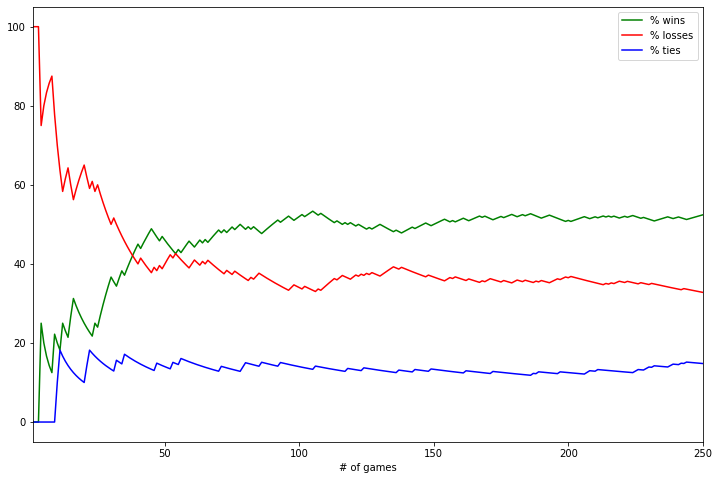

In [111]:
# calculate the results per game status
def game_status_lst(game_results,game_outcome):
    perc_lst = []
    num_outcome = 0
    for i in range(len(game_results)):
        if game_results[i]==game_outcome:
            num_outcome += 1
            perc_lst.append(num_outcome/(i+1)*100)
        else:
            perc_lst.append(num_outcome/(i+1)*100)
    return perc_lst

win_perc_lst = game_status_lst(results,'win')
loss_perc_lst = game_status_lst(results,'loss')
tie_perc_lst = game_status_lst(results,'tie')

# transform results per game status into a dataframe to vizualize
data = {'% wins': win_perc_lst, '% losses': loss_perc_lst, '% ties':tie_perc_lst}
results_df = pd.DataFrame(index=[i+1 for i in range(num_games)],data=data)
results_df['# of games'] = results_df.index

# visualize the results
num_view = 250
ax = plt.gca()
results_df.head(num_view).plot(kind='line',x='# of games',y='% wins',color='green', ax=ax)
results_df.head(num_view).plot(kind='line',x='# of games',y='% losses', color='red', ax=ax)
results_df.head(num_view).plot(kind='line',x='# of games',y='% ties', color='blue', ax=ax)
num_view
plt.show()

The graph shows that in the first few games, the computer loses often against the random player. However, as the Q-learning agent plays more games, it starts to win consistently against it's opponent, who is not adapting it's strategy over time. The numbers of tie games stays relatively consistent at a low number. Hence it can be concluded from this graph that we have successful taught the computer to be smarter at playing tic-tac-toe.

### Putting it all together

We now combine the ability to play against a human or computer into a single game. 
- Run the tic-tac-toe game from the Terminal (`python tic_tac_toe.py`). 
- The following prompt will appear: 'To play against the computer, enter 1. For multiplayer, enter 2:`
    - Type 1 and the Enter key to play against the computer.
    - Type 2 and the Enter key to play against the computer that was trained to play the game.
    - Hit Ctrl C to stop the game at any time.
- If you play against the computer, you will be Os and the computer goes first.
    - That is how the computer was taught to play the game. 
- There still is error checking in both games in case an invalid input is entered by the human player.
    - The computer will never choose an invalid action.
    - If you enter an invalid input, you will get an error message including the list of valid entries, and will be asked to retype your input.
    
In order to play against the computer, the computer will load the existing Q-table, which was updated after training using the Q-function, and will make it's selection based on this dataframe. To implement this, a `Computer` class was created including the methods listed below. 
- `check_add_state(state,q_learning_df)` - checks the state of the game and if not present, adds it to the Q-matrix `q_learning_df`. 
- `get_qlearning_data(self,state)` - converts the state as a string into a dataframe and filters the dataframe containing only the list of available moves.
- `select_action(self,extract_df,state)` - computer makes selection using the Q-matrix and chooses randomly if there is more than one highest number in the table.
- `convert_df(self,state,action_select)` - converts new state action action into a dataframe to display on the Terminal.
    - the 'E' is the state strings are converts to NaNs which are empty (`''`) when printed on the screen.
- `check_status(self,df,condition,player)` - checks to see what the game state is, i.e. 'win', 'loss', 'tie' or continue.
- `get_available_actions(self,df)` - retrieves list of available moves.

The code for the full game is included in the Appendix. 

### Appendix

##### Multiplayer tic-tac-toe game

In [3]:
# tic tac toe game
def instructions():
    os.system( 'clear' ) # clears terminal so that df is not printed each time
    print('Instructions: each player enters location of X (player 1) or O (player 2) using a 2 digit integer, e.g. 12 for row 1 column 2')
    print(tabulate(df.fillna(' '), headers='keys', tablefmt='fancy_grid'))
    
def play_game_multiplayer():
    count = 0 # we will be increment the count to signal when end of game has been reached
    input_lst = ['11', '12', '13', '21', '22', '23', '31', '32', '33'] 
    
    while count <= 9: # ends game when table is complete   
        # switches between player 1 and 2
        if (count % 2) == 0:
            player = ('Player 1','X')
        else:
            player = ('Player 2','O')
        
        while True:
            # gets player input
            player_input = str(input('{}({}): enter a 2-digit number representing a row and column: '.format(player[0],player[1]))) # input is a string

            if player_input in input_lst:
                # processes player input
                player_input.split()

                if player[0]=='Player 1':
                    df.iloc[int(player_input[0])-1,int(player_input[1])- 1] = 'X'
                else:
                    df.iloc[int(player_input[0])-1,int(player_input[1])- 1] = 'O'

                os.system( 'clear' )
                print(tabulate(df.fillna(' '), headers='keys', tablefmt='fancy_grid'))
                
                #updates the input_lst so that overwrite error do not happen 
                remove_number = player_input[0] + player_input[1]
                input_lst.remove(remove_number)
                break
            else:
                print('Invalid input. You can enter any number from the following list:' , ', '.join(input_lst))
                
        # checks if player won
        if (list(df[1].values) == (3 * [player[1]])) | (list(df[2].values) == (3 * [player[1]])) | (list(df[3].values) == (3 * [player[1]])): # wins by matching columns
            print ("{} wins".format(player[0]))
            sys.exit()
        if (list(df.iloc[0]) == (3 * [player[1]])) | (list(df.iloc[1]) == (3 * [player[1]])) | (list(df.iloc[2]) == (3 * [player[1]])): # wins by matching rows
            print ("{} wins".format(player[0]))
            sys.exit()
        if ([df.iloc[0, 0], df.iloc[1, 1], df.iloc[2, 2]] == (3 * [player[1]])) | ([df.iloc[0, 2], df.iloc[1, 1], df.iloc[2, 0]] == (3 * [player[1]])): # wins by matching columns
            print ("{} wins".format(player[0]))
            sys.exit()
        
        count += 1
        # checks if end of game is reached and no one won
        if count == 9: 
            print("It's a tie")
            sys.exit()

##### Training the computer to play tic-tac-toe

In [58]:
# check if state is in Q table, if not then add it to Q table
def check_add_state(state,q_learning_df):
    if not state in q_learning_df.index:
        add_row = pd.DataFrame([[0.0 for i in range(9)]], index = [state],columns=actions_lst)
        q_learning_df = q_learning_df.append(add_row)
    else: 
        pass
    return q_learning_df
 
# selection action
def select_action(state,q_learning_df):
    # get available moves
    available_moves = [] # where we will store available moves (actions)
    for i in range(len(state)):
        if state[i] == 'E':
            available_moves.append(actions_dict[i])

    # filter df by available moves
    df = q_learning_df.loc[state,:].to_frame()
    df = df[df.index.isin(available_moves)]

    if len(np.unique(df.values))==1: # check if all values are the same
        action = random.choice(df.index.tolist()) # choose random index
    else:
        action = df.idxmax().tolist()[0] # choose max
    return action

# update the board from action by creating a new state S(t+1)
def new_state_s1(action,state_t):
    action_idx = [k for k, v in actions_dict.items() if v == action][0] # get action index
    state_lst = list(state_t) # convert state str to list
    state_lst[action_idx] = 'X' # change the state based on action
    state_t1 = ''.join(state_lst)# convert state back from list back to string
    return state_t1

# check game status after player X move (win, draw of continue)
def game_status_player_X(state):
    if (
        # win by matching rows
        (state[:3] == 3*'X') or
        (state[3:6] == 3*'X') or 
        (state[6:9] == 3*'X') or
        # win by matching columns
        (state[0] + state[3] + state[6] == 3*'X') or
        (state[1] + state[4] + state[7] == 3*'X') or 
        (state[2] + state[5] + state[8] == 3*'X') or
        # win by diagonals
        (state[0] + state[4] + state[8] == 3*'X') or
        (state[2] + state[4] + state[6] == 3*'X')
    ):
        game_status = ('win',reward_win)
    elif 'E' not in state:
        game_status = ('tie',reward_tie)
    else:
        game_status = ('continue',reward_continue)
    return game_status

# check game status after player O move (loss, draw of continue)
def game_status_player_O(state):
    if (
        # loss by matching rows
        (state[:3] == 3*'O') or
        (state[3:6] == 3*'O') or 
        (state[6:9] == 3*'O') or
        # loss by matching columns
        (state[0] + state[3] + state[6] == 3*'O') or
        (state[1] + state[4] + state[7] == 3*'O') or 
        (state[2] + state[5] + state[8] == 3*'O') or
        # loss by diagonals
        (state[0] + state[4] + state[8] == 3*'O') or
        (state[2] + state[4] + state[6] == 3*'O')
    ):
        game_status = ('loss',reward_loss)
    elif 'E' not in state:
        game_status = ('tie',reward_tie)
    else:
        game_status = ('continue',reward_continue)
    return game_status

# calculate reward
def reward(game_status):
    return game_status[1]

# update Q table with Q-learning equation: 
# Q(S_t,A_t) <-- Q(S_t,A_t) + alpha * (reward + gamma * max_a_Q(S_t1,a) - Q(S_t,A_t))
def update_q_table(state_t,state_t1,action,q_learning_df,reward):
    q_value_t = q_learning_df.loc[state_t,action] # Q(S_t,A_t)
    if q_learning_df.loc[state_t1,:].isin([0.0 for i in range(9)]).all():
        max_a_t1 = random.choice(actions_lst)
    else:
        max_a_t1 = max(q_learning_df.loc[state_t1,:].to_dict(), key=q_learning_df.loc[state_t1,:].to_dict().get)
    max_q_t1 = q_learning_df.loc[state_t1,max_a_t1]# max_a_Q(S_t1,a)
    new_q_value_t = q_value_t + alpha*(reward + gamma*max_q_t1 - q_value_t) # update Q-value using formula
    q_learning_df.loc[state_t,max_a_t1] = new_q_value_t # update Q-value table using Q-value calculated above
    return q_learning_df

# opponent plays by making random selection 
def opponent_play(state_t1):
    available_moves = []
    for i in range(len(state_t1)):
        if state_t1[i] == 'E':
            available_moves.append(i)
    opponent_action = random.choice(available_moves) # action of player O
    state_t1_lst = list(state_t1) # convert state str to list
    state_t1_lst[opponent_action] = 'O' # change the state based on action
    state_t2 = ''.join(state_t1_lst)# convert state back from list back to string
    return state_t2

##### Full tic-tac-toe game - play against human or computer

In [111]:
class Computer:
    def convert_to_state(self,df):
        df_lst = []
        for i,j,k in df.values.tolist():
            df_lst.append(i)
            df_lst.append(j)
            df_lst.append(k)

        df_lst = [x if isinstance(x,str) else 'E' for x in df_lst]
        df_state = ''.join(df_lst)
        return df_state
    
    def get_qlearning_data(self,state):  
        if state in df_q_state.index:
            df_extract = df_q_state.loc[state,:].to_frame().reset_index()
            df_extract.rename(columns={'index': 'action'},inplace=True)
            state_lst = list(state)
            for i in range(len(df_extract.columns[1])):
                if state_lst[i] != 'E':
                    df_extract.drop(i,inplace=True)
                else:
                    pass
        else: 
            df_extract  = pd.DataFrame({'action': ['11','12','13','21','22','23','31','32','33'],
               state: [0.0]*9})
            state_lst = list(state)
            for i in range(len(df_extract.columns[1])):
                if state_lst[i] != 'E':
                    df_extract.drop(i,inplace=True)
                else:
                    pass
        return df_extract
    
    def select_action(self,extract_df,state):
        if extract_df[state].nunique() == 1:
            action = random.choice(extract_df.index)
        else:
            action = extract_df[state].idxmax()
        return action
    
    def convert_df(self,state,action_select):
        # convert state to list and update state based on action
        state_tolist = list(state)
        state_tolist[action_select] = 'X'
        
        #create new df based on new state while converting 'E' to np.nan
        new_df = pd.DataFrame({1: [np.nan if state_tolist[0]=='E' else state_tolist[0],
                                   np.nan if state_tolist[3]=='E' else state_tolist[3],
                                   np.nan if state_tolist[6]=='E'else state_tolist[6]],
           2: [np.nan if state_tolist[1]=='E' else state_tolist[1],
               np.nan if state_tolist[4]=='E' else state_tolist[4],
               np.nan if state_tolist[7]=='E'else state_tolist[7]],
           3: [np.nan if state_tolist[2]=='E' else state_tolist[2],
               np.nan if state_tolist[5]=='E' else state_tolist[5],
               np.nan if state_tolist[8]=='E'else state_tolist[8]],
            },columns=[1,2,3],index=[1,2,3])
        return new_df
    
    def check_status(self,df,condition,player):
        if (list(df[1].values) == (3 * [condition])) | (list(df[2].values) == (3 * [condition])) | (list(df[3].values) == (3 * [condition])): # wins by matching columns
            print ("{} wins".format(player))
            sys.exit()
        elif (list(df.iloc[0]) == (3 * [condition])) | (list(df.iloc[1]) == (3 * [condition])) | (list(df.iloc[2]) == (3 * [condition])): # wins by matching rows
            print ("{} wins".format(player))
            sys.exit()
        elif ([df.iloc[0, 0], df.iloc[1, 1], df.iloc[2, 2]] == (3 * [condition])) | ([df.iloc[0, 2], df.iloc[1, 1], df.iloc[2, 0]] == (3 * [condition])): # wins by matching columns
            print ("{} wins".format(player))
            sys.exit()
        else:
            status = 'continue'
        return status
    
    def get_available_actions(self,df):
        input_lst = []
        for i in range(len(df.values)):
            if (df.values[i][0] != 'X') and (df.values[i][0] != 'O'):
                input_lst.append(''.join([str(i+1),'1']))
            if (df.values[i][1] != 'X') and (df.values[i][1] != 'O'):
                input_lst.append(''.join([str(i+1),'2']))
            if (df.values[i][2] != 'X') and (df.values[i][2] != 'O'):
                input_lst.append(''.join([str(i+1),'3']))
            else:
                pass
        return input_lst

os.system('clear')
game_choice = input('To play against the computer, enter 1. For multiplayer, enter 2: ')
df_q_state = pd.read_csv('q_learning_df.csv',index_col=0) # load q-learning matrix
comp = Computer() # create computer/software agent object
df = pd.DataFrame(index = range(1,4), columns = range(1,4)) # creating empty df for the tic tac toe board

while True:
    if game_choice == '1':
        instructions()
        play_game_agent()
    elif game_choice == '2':
        while True:
            # computer plays
            state = comp.convert_to_state(df) # convert df to state (9-letter string)
            extract_df = comp.get_qlearning_data(state) # get applicable state from q-learning matrix
            action_select = comp.select_action(extract_df,state) # select action based on the q-learning matrix
            df = comp.convert_df(state,action_select) # action -->new state -->new df

            # check winner after computer plays
            game_status = comp.check_status(df,'X','Computer')

            # human plays
            while True:
                # get the input_lst (available input per the df)
                input_lst = comp.get_available_actions(df)
                # gets player input
                player_input = str(input('{}({}): enter a 2-digit number representing a row and column: '.format(player[0],player[1]))) # input is a string
                if player_input in input_lst:
                    # processes player input
                    player_input.split()
                    df.iloc[int(player_input[0])-1,int(player_input[1])- 1] = 'O'
                    os.system( 'clear' )
                    print(tabulate(df.fillna(' '), headers='keys', tablefmt='fancy_grid'))
                    #updates the input_lst so that overwrite error do not happen 
                    remove_number = player_input[0] + player_input[1]
                    input_lst.remove(remove_number)
                    break
            # check winner after human plays
            game_status = comp.check_status(df,'O','Human')
    else:
        game_choice = input('Invalid input. Enter Ctrl+C to exit, or enter 1 or 2 to play: ')